In [1]:
import pandas as pd
import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import xgboost as xgb
from xgboost import XGBClassifier

import shap

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## 1.  Model - No filter selection

#### 1. Load dataset 

In [2]:
df = pd.read_csv("./dataset/data-t1.csv")

In [3]:
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### 2. Clean dataset 

In [4]:
x = df.drop(columns=['diagnosis', 'id', 'Unnamed: 32'])
y = df['diagnosis'].map({"M": 0, "B": 1})

print(x.shape)

(569, 30)


In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

#### 3. Train Model

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

xgb_clf = XGBClassifier()
start = time.time()
xgb_clf.fit(x_train, y_train, eval_metric='aucpr')
stop = time.time()

print(f"Training time: {(stop - start) * 1000 }ms")

y_train_pred = xgb_clf.predict(x_train)
y_test_pred = xgb_clf.predict(x_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict = { }
scores_dict['XGBoost'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

Training time: 130.88107109069824ms
Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    148.0  250.0       1.0      398.0         398.0
_______________________________________________
Confusion Matrix: 
 [[148   0]
 [  0 250]]

Test Result:
Accuracy Score: 97.08%
_______________________________________________
Classification Report:
                   0           1  accuracy   macro avg  weighted avg
precision   0.983607    0.963636   0.97076    0.973621      0.971111
recall      0.937500    0.990654   0.97076    0.964077      0.970760
f1-score    0.960000    0.976959   0.97076    0.968479      0.970611
support    64.000000  107.000000   0.97076  171.000000    171.000000
________________

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


#### 4. Model Results

## 2. Apply Feature Selection (Shap)

In [7]:
shap.initjs()

explainer = shap.Explainer(xgb_clf)

start = time.time()
shap_values = explainer.shap_values(x_train)
stop = time.time()

print(f"Training time: {(stop - start) * 1000 }ms")

Training time: 14.495134353637695ms


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [8]:
import matplotlib.pyplot as plt

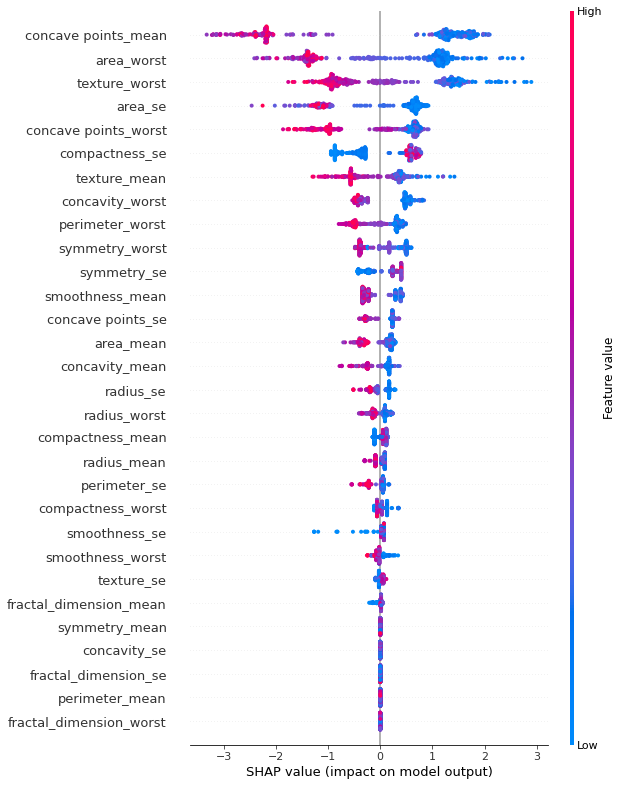

In [9]:
shap.summary_plot(shap_values, x_train, max_display=len(x.columns))

In [10]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(x_train.columns,vals)),columns=['feature_name','importance_value'])
feature_importance.sort_values(by=['importance_value'],ascending=False,inplace=True)

print(feature_importance.to_latex())

\begin{tabular}{llr}
\toprule
{} &             feature\_name &  importance\_value \\
\midrule
7  &      concave points\_mean &          1.760326 \\
23 &               area\_worst &          1.176283 \\
21 &            texture\_worst &          0.987075 \\
13 &                  area\_se &          0.823819 \\
27 &     concave points\_worst &          0.749554 \\
15 &           compactness\_se &          0.604814 \\
1  &             texture\_mean &          0.462405 \\
26 &          concavity\_worst &          0.452187 \\
22 &          perimeter\_worst &          0.362429 \\
28 &           symmetry\_worst &          0.356291 \\
18 &              symmetry\_se &          0.315224 \\
4  &          smoothness\_mean &          0.305626 \\
17 &        concave points\_se &          0.251884 \\
3  &                area\_mean &          0.233883 \\
6  &           concavity\_mean &          0.199347 \\
10 &                radius\_se &          0.149481 \\
20 &             radius\_worst &          

In [11]:
def get_feature_names(df, p_value=None):
    filtered_array = []
    for index, row in df.iterrows():
        if p_value != None:
            if row['importance_value'] >= p_value:
                filtered_array.append(row['feature_name'])
    
    return filtered_array

def get_sum(df):
    value = 0
    for index, row in df.iterrows():
        value = value + row['importance_value']

    return value

p = get_feature_names(feature_importance, p_value=0.0)
# print(p)
# print(get_sum(feature_importance))

In [12]:
# filtered_x = df[p]
# filtered_x.head()

In [13]:
# df_file = df[p] 
# df_file.to_csv('./dataset/filtered_csv')
# df_file.shape

In [16]:
import os

measures_data = []
featured_names = []

def get_measures(feature, classification_report, training_time, shap_value, storage): 
    accuracy = classification_report["accuracy"]
    measures_data.append([feature, accuracy, training_time, shap_value, storage])

def train_model(feature, shap_value):
    featured_names.append(feature)
    aux = df[featured_names]
    print(f"Shape: {aux.shape}s")
    
    x_train, x_test, y_train, y_test = train_test_split(aux, y, train_size=0.7)

    xgb_clf = XGBClassifier()
    start = time.time()
    xgb_clf.fit(x_train, y_train, eval_metric='aucpr')
    stop = time.time()
    
    y_test_pred = xgb_clf.predict(x_test)
    
    print(f"Training time: {(stop - start) * 1000 }ms")
    print(f"Training with features: {featured_names}s")
    print(os.stat('./dataset/data-t1.csv').st_size)
    
    storage = get_storage(featured_names)
    training_time = (stop - start) * 1000
    classification = classification_report(y_test, y_test_pred, output_dict=True)
    get_measures(feature, classification, training_time, shap_value, storage)
    
def get_storage(features):
    merged_features = ['diagnosis', 'id', 'Unnamed: 32'] + features
    temp = df[merged_features]
    temp.to_csv('./dataset/temp.csv')
    
    return os.stat('./dataset/temp.csv').st_size
            
def shap_all(df):
    for index, row in df.iterrows():
        train_model(row['feature_name'], row['importance_value'])

In [17]:
shap_all(feature_importance)goo
measures_df = pd.DataFrame(measures_data, columns = ['Feature Name', 'Accuracy', 'Training Time', 'Shap Value', 'Storage'])
measures_df.to_csv('test-1')

Shape: (569, 1)s
Training time: 128.97109985351562ms
Training with features: ['concave points_mean']s
125204
Shape: (569, 2)s


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y

Training time: 63.59410285949707ms
Training with features: ['concave points_mean', 'area_worst']s
125204
Shape: (569, 3)s
Training time: 67.3058032989502ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst']s
125204
Shape: (569, 4)s
Training time: 50.80413818359375ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se']s
125204
Shape: (569, 5)s


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

Training time: 51.972150802612305ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst']s
125204
Shape: (569, 6)s
Training time: 50.18901824951172ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se']s
125204
Shape: (569, 7)s
Training time: 56.1830997467041ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean']s
125204
Shape: (569, 8)s


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

Training time: 57.940006256103516ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst']s
125204
Shape: (569, 9)s
Training time: 76.5681266784668ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst']s
125204
Shape: (569, 10)s
Training time: 66.86902046203613ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst']s
125204
Shape: (569, 11)s
Training time: 108.43706130981445ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se']s
12520

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Shape: (569, 13)s
Training time: 110.0919246673584ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se']s
125204
Shape: (569, 14)s


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warnin

Training time: 80.87706565856934ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean']s
125204
Shape: (569, 15)s
Training time: 83.0841064453125ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean']s
125204
Shape: (569, 16)s
Training time: 58.210134506225586ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavit

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warnin

Training time: 92.36311912536621ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean']s
125204
Shape: (569, 19)s
Training time: 93.07003021240234ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean']s
125204
Shape: (569, 20)s


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Training time: 101.68290138244629ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean', 'perimeter_se']s
125204
Shape: (569, 21)s
Training time: 73.84800910949707ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean', 'perimeter_se', 'compactness_worst']s
125204
Shape: (569, 22)s


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Training time: 103.08313369750977ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean', 'perimeter_se', 'compactness_worst', 'smoothness_se']s
125204
Shape: (569, 23)s
Training time: 95.99685668945312ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean', 'perimeter_se', 'compactness_worst', 'smoothness_se', 'smoothness_worst']s
125204
Shape: (569, 24)s


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Training time: 113.64579200744629ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean', 'perimeter_se', 'compactness_worst', 'smoothness_se', 'smoothness_worst', 'texture_se']s
125204
Shape: (569, 25)s
Training time: 89.77007865905762ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean', 'perimeter_se', 'compactness_worst', 'smoothness_se', 'smoothness_worst', 'texture_se', 'fractal_dimension_

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Training time: 128.52025032043457ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean', 'perimeter_se', 'compactness_worst', 'smoothness_se', 'smoothness_worst', 'texture_se', 'fractal_dimension_mean', 'fractal_dimension_se']s
125204
Shape: (569, 27)s
Training time: 94.390869140625ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean', 'perimeter_se', 'compactness_worst', 'smoothness_se', 'smoo

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Training time: 107.25283622741699ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean', 'perimeter_se', 'compactness_worst', 'smoothness_se', 'smoothness_worst', 'texture_se', 'fractal_dimension_mean', 'fractal_dimension_se', 'concavity_se', 'symmetry_mean']s
125204
Shape: (569, 29)s
Training time: 142.8050994873047ms
Training with features: ['concave points_mean', 'area_worst', 'texture_worst', 'area_se', 'concave points_worst', 'compactness_se', 'texture_mean', 'concavity_worst', 'perimeter_worst', 'symmetry_worst', 'symmetry_se', 'smoothness_mean', 'concave points_se', 'area_mean', 'concavity_mean', 'radius_se', 'radius_worst', 'compactness_mean', 'radius_mean', 'perimeter_se', 'compact

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [18]:
measures_df.head()

,Feature Name,Accuracy,Training Time,Shap Value,Storage
0,concave points_mean,0.894737,128.971100,1.760326,12546
1,area_worst,0.912281,63.594103,1.176283,16124
2,texture_worst,0.959064,67.305803,0.987075,19489
3,area_se,0.964912,50.804138,0.823819,22868
4,concave points_worst,0.947368,51.972151,0.749554,27045


In [ ]:
import matplotlib.pyplot as plt

def show_accuracy_chart(df):
    temp_1 = df['Accuracy'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy (%)")
    plt.plot(temp_2, temp_1)
    
def show_storage_chart(df):
    temp_1 = df['Storage'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Storage (bytes)")
    plt.plot(temp_2, temp_1)
    
def show_training_chart(df):
    temp_1 = df['Training Time'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Time (ms)")
    plt.plot(temp_2, temp_1)

In [ ]:
show_accuracy_chart(measures_df)

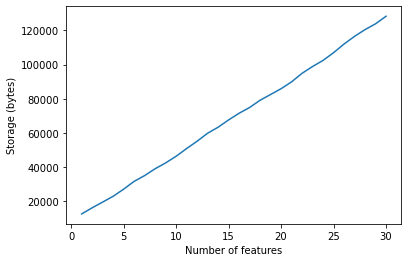

In [23]:
show_storage_chart(measures_df)

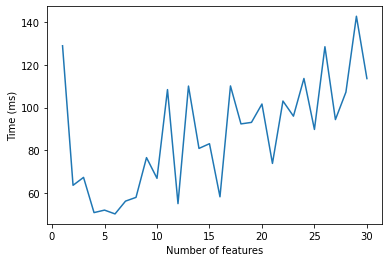

In [24]:
show_training_chart(measures_df)

## 3. Measure Prediction w/ feature Selection (Shap)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(filtered_x, y, train_size=0.7)

xgb_clf = XGBClassifier()
start = time.time()
xgb_clf.fit(x_train, y_train, eval_metric='aucpr')
stop = time.time()

print(f"Training time: {(stop - start) * 1000 }ms")

In [ ]:
y_train_pred = xgb_clf.predict(x_train)
y_test_pred = xgb_clf.predict(x_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict = { }
scores_dict['XGBoost'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}